In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
np.random.seed(42)
days = 200
sales = np.cumsum(np.random.randint(20, 50, size=days)) + 1000

data = pd.DataFrame({
    'Day': range(1, days + 1),
    'Sales': sales
})

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(data[['Sales']])


In [4]:
def create_sequences(dataset, time_step=10):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:i + time_step, 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_sequences(scaled_sales, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



In [6]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
early_stop = EarlyStopping(monitor='loss', patience=5)

model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1878
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.3082e-04 
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0359e-04
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1647e-04
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3770e-05
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4938e-05
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1554e-05 
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9881e-05 
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8037e-05 
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4183e-05 
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0

In [8]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [9]:
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 30.914699909887254
Test RMSE: 32.10796921913818


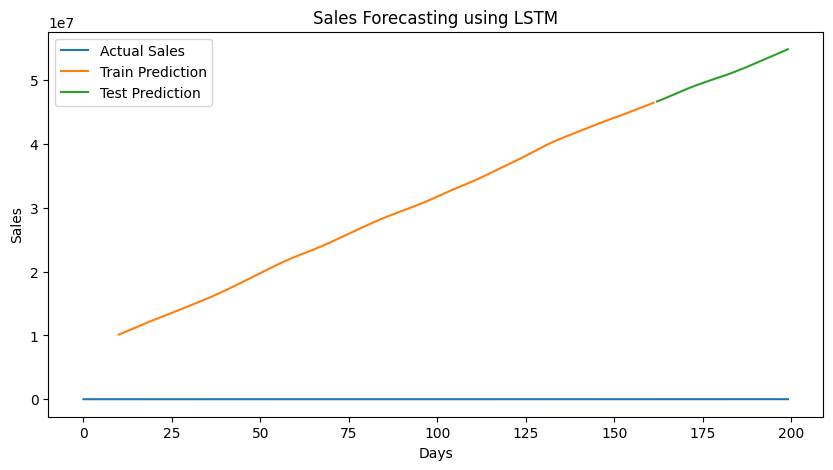

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(data['Sales'], label='Actual Sales')

train_plot = np.empty_like(scaled_sales)
train_plot[:] = np.nan
train_plot[time_step:train_size + time_step] = train_predict

test_plot = np.empty_like(scaled_sales)
test_plot[:] = np.nan
test_plot[train_size + time_step:] = test_predict

plt.plot(scaler.inverse_transform(train_plot), label='Train Prediction')
plt.plot(scaler.inverse_transform(test_plot), label='Test Prediction')

plt.legend()
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Sales Forecasting using LSTM')
plt.show()